In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install contractions
!pip install keras
!pip install konlpy
!pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 60.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 41.5 MB/s eta 0:00:00


In [ ]:
import torch
torch.cuda.is_available()

True

전처리

In [ ]:
import pandas as pd
import re
import contractions
import spacy
import en_core_web_sm
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from keras import Sequential
from keras.layers import Embedding, Dense, Dropout, Flatten, LSTM, Bidirectional
import matplotlib.pyplot as plt
import numpy as np
import keras
from konlpy.tag import Okt
from konlpy.tag import Kkma
from keras.models import load_model
import math
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from konlpy.tag import Okt
from gensim.models import Word2Vec
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Conv1D, GlobalMaxPooling1D
from sklearn.metrics import r2_score
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Activation
from sklearn.model_selection import KFold
import nltk
from nltk.tokenize import word_tokenize
import joblib
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

#LOAD DATA
nt = pd.read_csv('/content/drive/MyDrive/Capstone Design/youtubeData/totalYoutubeData_4.csv', encoding='utf-8')
nt = nt[['title_data', 'views_data']]
nt.columns = ['title', 'views']
print(nt.dtypes)


#문자열이 아닌 행 제거
nt = nt[nt['title'].apply(lambda x: isinstance(x, str))]
print(nt['title'].apply(type).unique())
nt['views'] = pd.to_numeric(nt['views'], errors='coerce')
nt = nt.dropna(subset=['views'])

# 'title' 컬럼에서 NaN 값이 있는 행 제거
nt = nt.dropna(subset=['title'])
nt = nt.dropna(subset=['views'])

#공백으로 이루어진 행을 제거
nt = nt[nt['title'].str.strip() != '']


Q1 = nt['views'].quantile(0.25)
print(Q1)
Q3 = nt['views'].quantile(0.75)
print(Q3)
IQR = Q3 - Q1

filtered_df = nt[(nt['views'] >= Q1) & (nt['views'] <= Q3)]

# 결과 출력
print("이상치 제거 전:")
print(nt)
print("이상치 제거 후:")
print(filtered_df)
filtered_df.to_csv('/content/drive/MyDrive/data.csv', index=False, encoding='utf-8')

title    object
views    object
dtype: object
[<class 'str'>]
11741.0
141562.75
이상치 제거 전:
                                                    title      views
0                       굉장한 아트록스 장인! 김민재님을 만났습니다ㄷㄷ [롤 스간]   234554.0
1                                  다리우스vs피오라[리메이크된다리우스강의]    59838.0
2         [롤 스간] 공격력 688 극딜 다리우스..모든 챔프 2초 안에 사르륵 녹는 마술..  1212979.0
3                    [롤 스간] 다리우스 VS 레넥톤 ㅣ 버스기사 폭행하는 팀원...    27056.0
4                           스간다리우스vs윤귀중카타리나◆1 vs 1 장인대전乃◆    17679.0
...                                                   ...        ...
182784                                   거대한 갭메우기가 시작됩니다.    10959.0
182785  통계 사상 경기 인천 최대 폭등 기록! 예전 가격으로 다시 돌아가지 않는 인플레이션...    25273.0
182786  화폐개혁 그냥 떠본게 아닌 것 같다? 디플레이션 공포와 부동산 시장의 미래는? -놀...    83201.0
182787  [속보] 50년 만기 주택담보대출 중단 & 나이 제한 걸리고 있네요. 서두르셔야 할...     2600.0
182788   6월부터 전월세 신고제 시작! 임차 시장 자금 흐름 투명화와 그 결과는 바로 이것이다!    47154.0

[182784 rows x 2 columns]
이상치 제거 후:
                                             

In [ ]:
# MinMaxScaler 객체 생성
scaler = MinMaxScaler()

# '조회수' 열 데이터 추출
views_data = filtered_df['views'].values.reshape(-1, 1)  # 2차원 배열로 변환

# 조회수 데이터 정규화 (0에서 1 사이의 값으로 스케일링)
views_normalized = scaler.fit_transform(views_data)

# 정규화된 값을 'normalized_data' 열에 추가
filtered_df['normalized_data'] = views_normalized

<ipython-input-9-632bc28d399d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['normalized_data'] = views_normalized


In [ ]:
normalized_title=filtered_df['title']
views=filtered_df['views']
normalized_views=filtered_df['normalized_data']
normalized_data={'title':normalized_title,'views':views,'normalized_views':normalized_views}
normalized_df=pd.DataFrame(normalized_data)
normalized_df

,title,views,normalized_views
1,다리우스vs피오라[리메이크된다리우스강의],59838.0,0.370487
3,[롤 스간] 다리우스 VS 레넥톤 ㅣ 버스기사 폭행하는 팀원...,27056.0,0.117970
4,스간다리우스vs윤귀중카타리나◆1 vs 1 장인대전乃◆,17679.0,0.045740
6,롤10년차..처음 겪는 마스터 솔랭 [롤 스간],61872.0,0.386155
7,"무한 갱킹 오는 상대 정글에 ""극대노 스간"" 레넥톤 참교육까지! [롤 스간]",83061.0,0.549372
...,...,...,...
182782,궁금하셨죠? 서울 안의 공급지 분석! 3기신도시와 서울 소규모 공급 과연 서울이 ...,12228.0,0.003751
182783,고분양가 논란! 서울보다 비싼 덕은지구! 그냥 버리기엔 아까울 수도..,13656.0,0.014751
182785,통계 사상 경기 인천 최대 폭등 기록! 예전 가격으로 다시 돌아가지 않는 인플레이션...,25273.0,0.104236
182786,화폐개혁 그냥 떠본게 아닌 것 같다? 디플레이션 공포와 부동산 시장의 미래는? -놀...,83201.0,0.550450


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(normalized_df['title'], normalized_df['normalized_views'], test_size=0.2, random_state=42)

In [ ]:
X_train

117501                          킹크랩 집에서 찌기 싫다면 꼭 시청하세요~~!!!
128309                중학생 패스농구에 농락당하다 3on3농구 훕코리아가 간다 상현중학교
115506    [최신시세정보] 명절전  꽃게, 전어, 새우 등 수산물 시세 확인하세요 ~   9월...
127344           고양이를 통덫으로 잡는 올바른 방법(통덫에 잘 안들어가는 고양이 잡는 방법)
48596                                     드디어 맛 본 한국 삼겹살 🇨🇴
                                ...                        
11316                                크타니드 탄생 비화(feat.핑맨속이기)
109131                                  헤일로(HALO) 공식팬카페 오픈!
153442                  쿵후영화의 최절정 영춘권의 제왕 원표의 패가자 2부 리뷰입니다.
1457                          인생3회차★[주식왕용느]욕심금지욕심금지욕심금지욕심금지
29355     Ep 4. 연고전? 고연전? 맞붙은 숙명의 라이벌, 고려대학교 “테라” vs 연세대...
Name: title, Length: 73114, dtype: object

In [ ]:
X_test

119570    오랜만에 메이크업 같이 준비해요 | GRWM (Feat. ...
125741     햄스터의 실제 사냥 실력 | 야생 본능 로봇벌레 잡기 | 햄찌 장난감 | 심심타임 심심
28038                백색소음 - 비소리 8시간 -우산 파라솔 위로 떨어지는 빗소리 동영상
67124     일론 머스크는 육아중 | 슈퍼볼 뒤흔든 위켄드의 비밀 | 저스틴 비버의 우주선 | ...
85403     SUB CC] 따뜻함이 가득핀 꽃 자수 달력 2편, 프랑스 자수 Cozy&Fluff...
                                ...                        
128673                                 스크린골프 그린빠르기 거리조절연습방법
26679     임한별 - 이별하러 가는 길 (The Way To Say Goodbye) Offic...
72837                            살 뺄때 도움되는 일주일 다이어트 도시락 만들기
82167              [예능] 오은영의 금쪽 상담소 20회_220218_최양락♥팽현숙 부부 편
117101    miniature - Sylvanian Families Mini Series② / ...
Name: title, Length: 18279, dtype: object

텍스트 토큰화

In [ ]:
# Okt 형태소 분석기 초기화
okt = Okt()

# NLTK의 word_tokenize 함수를 사용하여 영어 텍스트 토큰화
def tokenize(text):
    # 한글, 영어, 숫자만 남기고 나머지 문자 제거
    cleaned_text = re.sub('[^가-힣a-zA-Z0-9]', ' ', text)
    # 한글 토큰화 (Okt 사용)
    tokens = okt.morphs(cleaned_text)
    return tokens

# X_train의 각 요소에 대해 한 번만 토큰화 함수를 호출하도록 수정
X_train_tokenized = X_train.apply(lambda x: tokenize(x))
X_train_tokenized

117501                    [킹크랩, 집, 에서, 찌기, 싫다면, 꼭, 시청, 하세요]
128309    [중학생, 패스, 농구, 에, 농락, 당하다, 3, on, 3, 농구, 훕, 코리아...
115506    [최신, 시세, 정보, 명절, 전, 꽃게, 전어, 새우, 등, 수산물, 시세, 확인...
127344    [고양이, 를, 통덫, 으로, 잡는, 올바른, 방법, 통덫, 에, 잘, 안, 들어가...
48596                                  [드디어, 맛, 본, 한국, 삼겹살]
                                ...                        
11316                 [크, 타, 니드, 탄생, 비화, feat, 핑, 맨, 속, 이기]
109131                             [헤일로, HALO, 공식, 팬카페, 오픈]
153442    [쿵후, 영화, 의, 최, 절정, 영춘권, 의, 제왕, 원표, 의, 패가, 자, 2...
1457      [인생, 3회, 차, 주식, 왕, 용느, 욕심, 금지, 욕심, 금지, 욕심, 금지,...
29355     [Ep, 4, 연고전, 고연전, 맞붙은, 숙명, 의, 라이벌, 고려대학교, 테라, ...
Name: title, Length: 73114, dtype: object


텍스트 벡터화

In [ ]:
# Tokenizer를 사용하여 단어를 숫자 시퀀스로 변환
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_tokenized)
X_train_sequences = tokenizer.texts_to_sequences(X_train_tokenized)

# 시퀀스 데이터를 패딩하여 길이를 맞춤
max_length = max([len(seq) for seq in X_train_sequences])
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post')

# Word2Vec 모델 학습
word2vec_model = Word2Vec(sentences=X_train_tokenized, vector_size=100, window=5, min_count=1, workers=4, sg=1)

# 임베딩 매트릭스 생성
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 100))
for word, idx in tokenizer.word_index.items():
    try:
        embedding_vector = word2vec_model.wv[word]
        # 'gta'와 같은 단어가 없을 경우 embedding_vector는 None이 됩니다.
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
    except KeyError:
        # Word2Vec 모델에 해당 단어가 없는 경우 KeyError가 발생하며 embedding_vector는 None이 됩니다.
        embedding_vector = None

In [ ]:
print(word2vec_model.wv.vectors.shape)
wv_result=word2vec_model.wv.most_similar("먹방")
print(wv_result)

(76110, 100)
[('mukbang', 0.8117724657058716), ('터민', 0.7966402173042297), ('공혁준', 0.773164689540863), ('Mukbang', 0.7704236507415771), ('치킨', 0.7684570550918579), ('초밥', 0.7660167813301086), ('족발', 0.7659081816673279), ('혜지', 0.7629050612449646), ('찜닭', 0.7615747451782227), ('만리', 0.7590804100036621)]


모델 학습

In [ ]:
#모델 정의
model = Sequential()

# 임베딩 레이어 설정
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1,
                            output_dim=100,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)  # 사전 훈련된 임베딩을 사용하므로 trainable을 False로 설정

model.add(embedding_layer)
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1, activation='linear'))  # 회귀 모델을 위한 출력 레이어

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

# 모델 요약 출력
model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  # 검증 손실이 10 에포크 동안 감소하지 않으면 학습 종료
# 모델 학습
model_fit=model.fit(X_train_padded, y_train, epochs=100, batch_size=32, validation_split=0.2,callbacks=[early_stopping])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 47, 100)           7145800   
                                                                 
 bidirectional (Bidirection  (None, 64)                34048     
 al)                                                             
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 7179913 (27.39 MB)
Trainable params: 34113 (133.25 KB)
Non-trainable params: 7145800 (27.26 MB)
_________________________________________________________________
Epoch 1/100
1828/1828 [==============================] - 28s 10ms/step - loss: 0.0732 - mse: 0.0732 - val_loss: 0.0707 - val_mse: 0.0707
Epoch 2/100
1828/1828 [==============================] - 16s 9ms/step - l

In [ ]:
X_test_tokenized = X_test.apply(lambda x: tokenize(x))

# LSTM 모델에 입력할 형태로 시퀀스 데이터 변환
X_test_sequences = tokenizer.texts_to_sequences(X_test_tokenized)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding='post')

In [ ]:
# LSTM 모델에서 예측값 계산
predictions = model.predict(X_test_padded)

# 정규화된 조회수 열 데이터로 예측값 역변환 (원래 스케일로 변환)
predicted_views = scaler.inverse_transform(predictions).astype(int)

y_test_np = np.array(y_test).reshape(-1, 1)
y_test_original_scale = scaler.inverse_transform(y_test_np).astype(int)

# 예측값과 실제값 간의 평가 (예를 들어, 평균 제곱 오차 계산)
mse = mean_squared_error(y_test_original_scale, predicted_views)
mae=mean_absolute_error(y_test_original_scale, predicted_views)
rmse=np.sqrt(mse)

def MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"테스트 조회수 데이터의 평균: {y_test_original_scale.mean():.0f}")
print(f"Mean Absolute Error: {mae:.0f}")
print(f"Mean Absolute Percentage Error: {MAPE(y_test_original_scale,predicted_views):.0f}")

572/572 [==============================] - 2s 3ms/step
테스트 조회수 데이터의 평균: 53492
Mean Absolute Error: 28189
Mean Absolute Percentage Error: 83


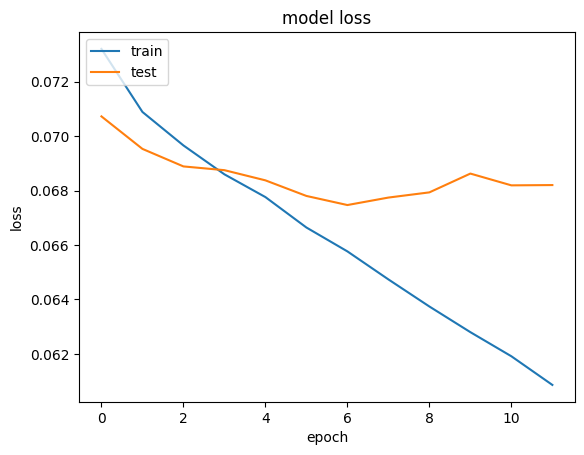

In [ ]:
# PLOT
plt.plot(model_fit.history['loss'])
plt.plot(model_fit.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

모델 저장

In [ ]:
# scaler 객체를 저장
joblib.dump(scaler, '/content/drive/MyDrive/Capstone Design/youtubeViewsPrediction/model/scaler.pkl')

['/content/drive/MyDrive/Capstone Design/youtubeViewsPrediction/model/scaler.pkl']

In [ ]:
model.save("/content/drive/MyDrive/Capstone Design/youtubeViewsPrediction/model/BiLstm.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#PREDICT NEW TITLE
with open('/content/drive/MyDrive/Capstone Design/youtubeViewsPrediction/model/lstm.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

모델 테스트

In [ ]:
from keras.models import load_model
import pickle
with open('/content/drive/MyDrive/Capstone Design/youtubeViewsPrediction/model/lstm.pickle', 'rb') as handle:
    loaded_tokenizer = pickle.load(handle)
model = load_model('/content/drive/MyDrive/Capstone Design/youtubeViewsPrediction/model/BiLstm.h5')

def predictView(title):
    import math

    input_str = title
    input_df = pd.DataFrame(columns=['title', 'view'])
    input_df = input_df.append({'title' : input_str} , ignore_index=True)
    seq = loaded_tokenizer.texts_to_sequences(input_df['title'].values)
    padded = pad_sequences(seq, 47)
    pred = model.predict(padded)
    predicted_views = scaler.inverse_transform(pred).astype(int)[0][0]

    return predicted_views

#TEST

print(predictView("다이어트시 자주하는 3가지 실수"))

<ipython-input-35-857e57079488>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  input_df = input_df.append({'title' : input_str} , ignore_index=True)


1/1 [==============================] - 2s 2s/step
62366
